In [49]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import matplotlib.image as mpimg
from scipy.ndimage import rotate
from itertools import product
from tqdm import tqdm


animation.writer = animation.writers['ffmpeg']

In [15]:
def lunar_lander(pos_init, v_init, alpha=10., beta=25., gamma=3., G=2., t_steps=200, animate_file=None):
    '''Find the optimal control and trajectory for the lunar lander.

        Parameters:
            pos_init (tuple) : x and y coordinates defining the starting position of the lunar lander
            v_init (float) : the lander's starting velocity in the x direction
            alpha (float) : the weight on the magnitude of the lander's acceleration over time
            beta (float) : the weight on the magnitude of the lander's final velocity (both x and y directions)
            gamma (float) : the weight on the final time
            G (float) : acceleration due to gravity on the moon
            t_steps : number of time steps to evaluate
            animate_file : if a string filename is passed in, an animation will be created and saved in the 
                specified file name. If no filename is passed in, the function will return without creating an
                animation
        
        Returns: 
            t_vals (ndarray) : the time values corresponding with the solution values
            x (ndarray) : the lander's trajectory (position) in the x direction
            y (ndarray) : the lander's trajectory (position) in the y direction
            xp (ndarray) : the lander's velocity in the x direction
            yp (ndarray) : the lander's velocity in the y direction
            ux (ndarray) : the optimal control (acceleration) in the x direction
            uy (ndarray) : the optimal control (acceleration) in the y direction
            tf (float) : the optimal landing time
    '''

    x_init, y_init = pos_init

    # Define the ODE's associated with state and costate evolution
    def ode(t, y, p):
        tf = p[0]
        return tf * np.array([
            y[2],
            y[3],
            y[6] / (2*alpha),
            y[7] / (2*alpha) - G,
            np.zeros_like(y[0]), 
            np.zeros_like(y[0]), 
            y[4],
            y[5]
        ])
    
    # Define the boundary conditions
    # BC's 1-5 come from known initial and final conditions
    # BC's 6-8 come from conditions on the costate
    # BC 9 comes from the final condition on the Hamiltonian relating to variable final time
    def bc(ya, yb, p):
        tf = p[0]
        uxf = yb[6] / (2*alpha)
        uyf = yb[7] / (2*alpha)
        return np.array([
            ya[0] - x_init,
            ya[1] - y_init,
            ya[2] - v_init,
            ya[3],
            yb[1],
            yb[4],
            yb[6] - 2*beta*yb[2],
            yb[7] - 2*beta*yb[3],
            yb[4]*yb[2] + yb[5]*yb[3] + yb[6]*uxf + yb[7]*(uyf - G) - alpha*(uxf**2 + uyf**2) + gamma
        ])
    
    # Define the initial guess
    tf_0 = 20
    t_eval = np.linspace(0, 1, t_steps) 
    y0 = np.ones((8, t_steps))

    y0[0] *= x_init                            # x constant
    y0[1] = np.linspace(y_init, 0, t_steps)    # y goes to 0
    y0[2] = np.linspace(v_init, 0, t_steps)    # vx goes to 0
    

    # Solve the ODE
    sol = solve_bvp(ode, bc, t_eval, y0, p=np.array([tf_0]), max_nodes=30000)
    tf = sol.p[0]

    # Extract the different elements of the solution
    x = sol.y[0]
    y = sol.y[1]
    xp = sol.y[2]
    yp = sol.y[3]
    ux = sol.y[6] / (2*alpha)       # compute controls from costates
    uy = sol.y[7] / (2*alpha)
    t_vals = sol.x * tf

    return t_vals, x, y, xp, yp, ux, uy, tf

pos = (5., 10.)
v = 1.
t, x, y, xp, yp, ux, uy, tf = lunar_lander(pos, v, beta=100, t_steps=1000)

0.0896176316067705


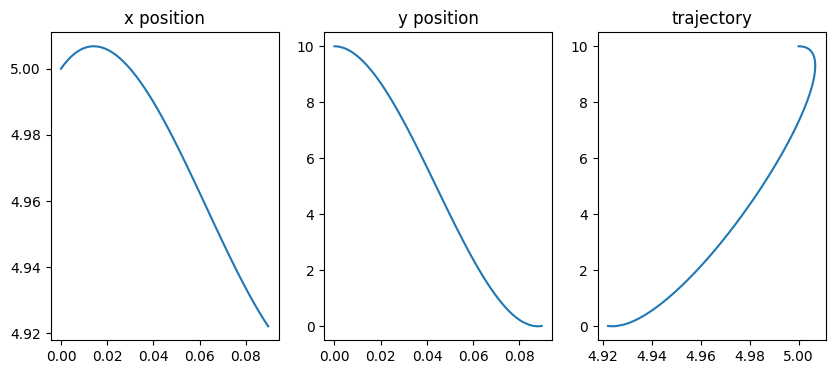

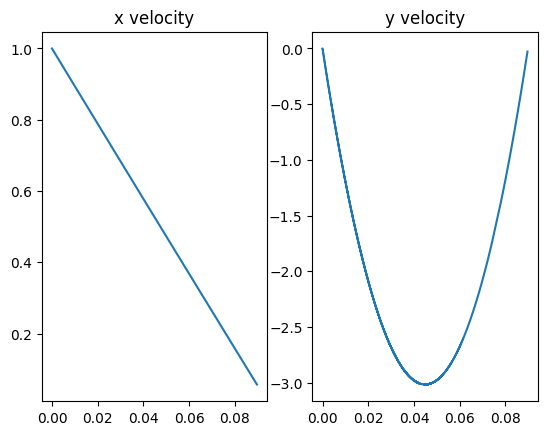

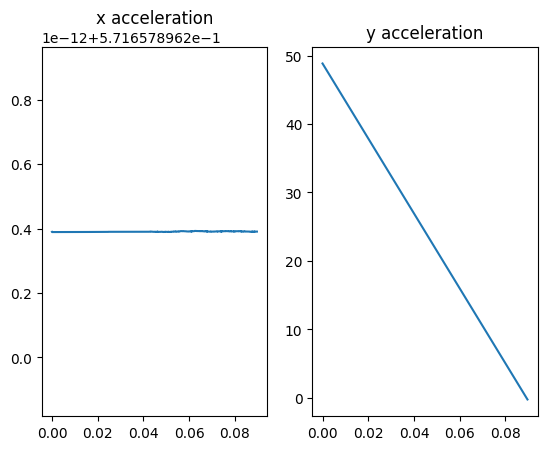

In [16]:
print(tf)
plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.plot(t, x)
plt.title("x position")
plt.subplot(132)
plt.plot(t, y)
plt.title("y position")
plt.subplot(133)
plt.plot(x, y)
plt.title("trajectory")
plt.show()

plt.subplot(121)
plt.plot(t, xp)
plt.title("x velocity")
plt.subplot(122)
plt.plot(t, yp)
plt.title("y velocity")
plt.show()

plt.subplot(121)
plt.plot(t, ux)
plt.title("x acceleration")
plt.subplot(122)
plt.plot(t, uy)
plt.title("y acceleration")
plt.show()


In [ ]:
t, x, y, xp, yp, ux, uy, tf = lunar_lander(pos, v)

In [15]:
np.arctan(ux/uy)

array([ 0.23514968,  0.23517239,  0.2351951 , ..., -0.37132073,
       -0.37126567, -0.37121061])

array([-1.57079633, -1.57064933, -1.57050279, ..., -0.37127005,
       -0.37124018, -0.37121061])

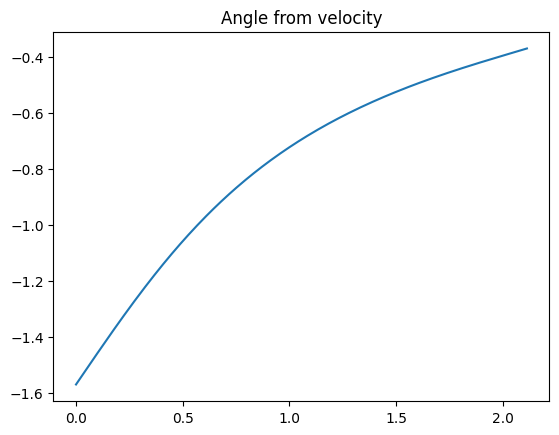

In [ ]:
plt.plot(t, np.arctan(xp/yp))
plt.title("Angle from velocity")
plt
plt.show()

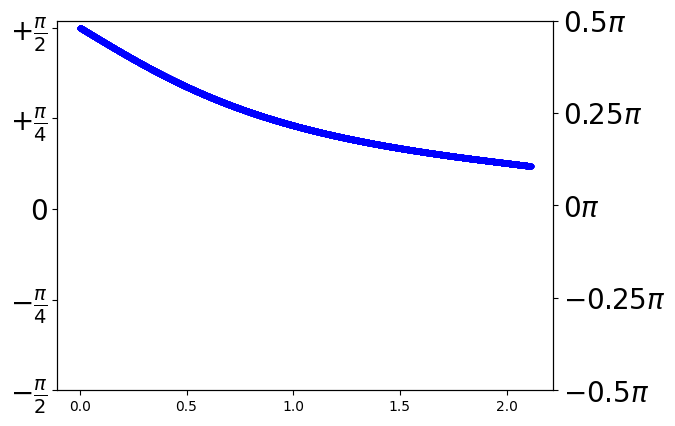

In [20]:
import matplotlib.pyplot as plt
import numpy as np

x=t
y=-np.arctan(xp/yp)

fig = plt.figure()
ax  = fig.add_subplot(111)

ax.plot(x,y,'b.')

y_pi   = y/np.pi
unit   = 0.25
y_tick = np.arange(-0.5, 0.5+unit, unit)

y_label = [r"$-\frac{\pi}{2}$", r"$-\frac{\pi}{4}$", r"$0$", r"$+\frac{\pi}{4}$",   r"$+\frac{\pi}{2}$"]
ax.set_yticks(y_tick*np.pi)
ax.set_yticklabels(y_label, fontsize=20)

y_label2 = [r"$" + format(r, ".2g")+ r"\pi$" for r in y_tick]
ax2 = ax.twinx()
ax2.set_yticks(y_tick*np.pi)
ax2.set_yticklabels(y_label2, fontsize=20)

plt.show()

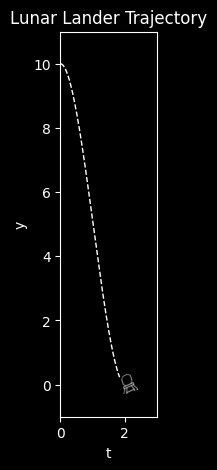

In [ ]:
plt.style.use('dark_background')
def lander_anim(filename: str):
    # solve the bvp
    ts, xs, ys, x_vel, y_vel, ux, uy, tf = lunar_lander(pos, v)

    plt.clf()
    
    # setup all of the parameters for the problem
    Y_PLOT_LIMS = (0, 20)
    PATH_COLOR = "#ffffff"

    # setup the plot
    plt.title(f"Lunar Lander Trajectory")
    plt.gcf().set_size_inches(10,5)
    xlims = (0, 3)
    ylims = (-1, 11)
    plt.xlim(*xlims)
    plt.ylim(*ylims)
    plt.xlabel("t")
    plt.ylabel("y")

    # # plot the background
    # background = mpimg.imread('images/used/background.jpg')
    # plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)
        
    # plot the lander
    LANDER_SIZE = .3
    xmin, xmax = ts[-1]-LANDER_SIZE, ts[-1]+LANDER_SIZE
    ymin, ymax = ys[-1]-LANDER_SIZE, ys[-1]+LANDER_SIZE
    img = mpimg.imread('./lander.png')

    # plot the trajectory
    line, = plt.gca().plot([], [], "--", linewidth=1, color=PATH_COLOR)

    # Plot initial position of the lander
    lander = plt.imshow(img, extent=[ts[0] - LANDER_SIZE, ts[0] + LANDER_SIZE, ys[0] - LANDER_SIZE, ys[0] + LANDER_SIZE], aspect='equal', zorder=2)

    # Rotate lander image based on velocity
    def rotate_lander(vel_x, vel_y):
        angle = np.degrees(-np.arctan(vel_x / vel_y))
        rotated_img = rotate(img, angle, reshape=False)
        rotated_img = np.clip(rotated_img, 0, 1)
        return rotated_img

    # Define update function
    def update(frame):
        print(frame, "/", len(ts), end="\r")
        # Update trajectory
        line.set_data(ts[:frame], ys[:frame])
        
        # Update lander position and rotation relative to velocity
        vel_x = x_vel[frame]
        vel_y = y_vel[frame]
        lander.set_data(rotate_lander(vel_x, vel_y))
        
        # Update lander position
        lander.set_extent([ts[frame] - LANDER_SIZE, ts[frame] + LANDER_SIZE, ys[frame] - LANDER_SIZE, ys[frame] + LANDER_SIZE])

    ani = FuncAnimation(plt.gcf(), update, frames=range(0, len(ts), 60), interval=60, repeat=False)
    ani.save(filename)

lander_anim(filename='test4_degree_from_accel.mp4')

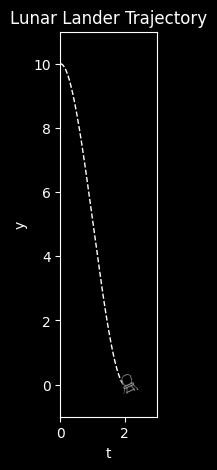

In [71]:
plt.style.use('dark_background')
def lander_anim(filename: str):
    # solve the bvp
    ts, xs, ys, x_vel, y_vel, ux, uy, tf = lunar_lander(pos, v)

    plt.clf()
    
    # setup all of the parameters for the problem
    Y_PLOT_LIMS = (0, 20)
    PATH_COLOR = "#ffffff"

    # setup the plot
    plt.title(f"Lunar Lander Trajectory")
    plt.gcf().set_size_inches(10,5)
    xlims = (0, 3)
    ylims = (-1, 11)
    plt.xlim(*xlims)
    plt.ylim(*ylims)
    plt.xlabel("t")
    plt.ylabel("y")

    # # plot the background
    # background = mpimg.imread('images/used/background.jpg')
    # plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)
        
    # plot the lander
    LANDER_SIZE = .3
    xmin, xmax = ts[-1]-LANDER_SIZE, ts[-1]+LANDER_SIZE
    ymin, ymax = ys[-1]-LANDER_SIZE, ys[-1]+LANDER_SIZE
    img = mpimg.imread('./lander.png')

    # plot the trajectory
    line, = plt.gca().plot([], [], "--", linewidth=1, color=PATH_COLOR)

    # Plot initial position of the lander
    lander = plt.imshow(img, extent=[ts[0] - LANDER_SIZE, ts[0] + LANDER_SIZE, ys[0] - LANDER_SIZE, ys[0] + LANDER_SIZE], aspect='equal', zorder=2)

    # Rotate lander image based on velocity
    def rotate_lander(vel_x, vel_y):
        angle = np.degrees(-np.arctan(vel_x / vel_y))
        rotated_img = rotate(img, angle, reshape=False)
        rotated_img = np.clip(rotated_img, 0, 1)
        return rotated_img

    # Define update function
    def update(frame):
        print(frame, "/", len(ts), end="\r")
        # Update trajectory
        line.set_data(ts[:frame], ys[:frame])
        
        # Update lander position and rotation relative to velocity
        vel_x = x_vel[frame]
        vel_y = y_vel[frame]
        lander.set_data(rotate_lander(vel_x, vel_y))
        
        # Update lander position
        lander.set_extent([ts[frame] - LANDER_SIZE, ts[frame] + LANDER_SIZE, ys[frame] - LANDER_SIZE, ys[frame] + LANDER_SIZE])

    ani = FuncAnimation(plt.gcf(), update, frames=range(0, len(ts), 60), interval=60, repeat=False)
    ani.save(filename)

lander_anim(filename='test4_degree_from_accel.mp4')

array([[ 0.4868516 ,  0.4868516 ,  0.4868516 , ...,  0.4868516 ,
         0.4868516 ,  0.4868516 ],
       [ 2.03208783,  2.03188417,  2.03168051, ..., -1.25031433,
        -1.25051799, -1.25072165]])

In [ ]:
ts = [100, 1_000, 10_000, 100_000, 1_000_000]
betas = [0, 1, 50, 100, 500, 600, 700, 800, 900, 1000, 10000]
results_dict = { f'{t}': {f'{b}':0 for b in betas} for t in ts }
for t, beta in tqdm(product(ts, betas)):
    pos = (5., 10.)
    v = 1.
    ts, xs, ys, x_vel, y_vel, ux, uy, tf = lunar_lander(pos, v, beta=800, t_steps=10000)
    results_dict[f'{t}'][f'{beta}']['final_vel_mag'] = np.linalg.norm(np.vstack([x_vel, y_vel]).T, axis=1)[-1]
    results_dict[f'{t}'][f'{beta}']['final_accel_mag'] = np.linalg.norm(np.vstack([ux, uy]).T, axis=1)[-1]



In [ ]:
resuts 

In [56]:
results_dict

{'100': {'0': 0,
  '1': 0,
  '50': 0,
  '100': 0,
  '500': 0,
  '600': 0,
  '700': 0,
  '800': 0,
  '900': 0,
  '1000': 0,
  '10000': 0},
 '1000': {'0': 0,
  '1': 0,
  '50': 0,
  '100': 0,
  '500': 0,
  '600': 0,
  '700': 0,
  '800': 0,
  '900': 0,
  '1000': 0,
  '10000': 0},
 '10000': {'0': 0,
  '1': 0,
  '50': 0,
  '100': 0,
  '500': 0,
  '600': 0,
  '700': 0,
  '800': 0,
  '900': 0,
  '1000': 0,
  '10000': 0},
 '100000': {'0': 0,
  '1': 0,
  '50': 0,
  '100': 0,
  '500': 0,
  '600': 0,
  '700': 0,
  '800': 0,
  '900': 0,
  '1000': 0,
  '10000': 0},
 '1000000': {'0': 0,
  '1': 0,
  '50': 0,
  '100': 0,
  '500': 0,
  '600': 0,
  '700': 0,
  '800': 0,
  '900': 0,
  '1000': 0,
  '10000': 0}}

In [ ]:
re

In [46]:
pos = (5., 10.)
v = 1.
ts, xs, ys, x_vel, y_vel, ux, uy, tf = lunar_lander(pos, v, beta=800, t_steps=10000)

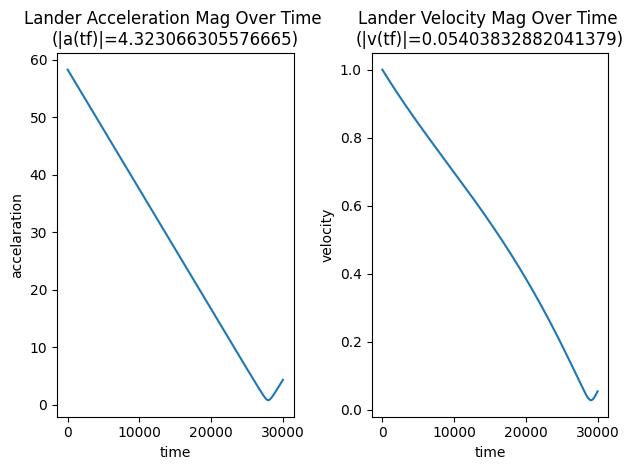

In [47]:

accel_mag = np.linalg.norm(np.vstack([ux, uy]).T, axis=1)
plt.subplot(121)
plt.plot(accel_mag)
plt.xlabel('time')
plt.ylabel('accelaration')
plt.title(f'Lander Acceleration Mag Over Time \n(|a(tf)|={accel_mag[-1]})')

vel_mag = np.linalg.norm(np.vstack([x_vel, y_vel]).T, axis=1)
plt.subplot(122)
plt.plot(vel_mag)
plt.xlabel('time')
plt.ylabel('velocity')
plt.title(f'Lander Velocity Mag Over Time \n(|v(tf)|={vel_mag[-1]})')

plt.tight_layout()
plt.show()

In [ ]:
plt.style.use('dark_background')
def lander_plot(filename: str):
    # solve the bvp
    ts, xs, ys, x_vel, y_vel, ux, uy, tf = lunar_lander(pos, v)

    plt.clf()
    
    # setup all of the parameters for the problem
    Y_PLOT_LIMS = (0, 20)
    PATH_COLOR = "#ffffff"

    # setup the plot
    plt.title(f"Lunar Lander Trajectory")
    plt.gcf().set_size_inches(10,5)
    xlims = (0, 3)
    ylims = (-1, 11)
    plt.xlim(*xlims)
    plt.ylim(*ylims)
    plt.xlabel("t")
    plt.ylabel("y")

    # # plot the background
    # background = mpimg.imread('images/used/background.jpg')
    # plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)
        
    # plot the lander
    LANDER_SIZE = .3
    # xmin, xmax = ts[-1]-LANDER_SIZE, ts[-1]+LANDER_SIZE
    # ymin, ymax = ys[-1]-LANDER_SIZE, ys[-1]+LANDER_SIZE
    img = mpimg.imread('./lander.png')

    # plot the trajectory
    line, = plt.gca().plot([], [], "--", linewidth=1, color=PATH_COLOR)

    # Plot initial position of the lander
    lander = plt.imshow(img, extent=[ts[0] - LANDER_SIZE, ts[0] + LANDER_SIZE, ys[0] - LANDER_SIZE, ys[0] + LANDER_SIZE], aspect='equal', zorder=2)

    plt.show()
    # # Rotate lander image based on velocity
    # def rotate_lander(vel_x, vel_y):
    #     angle = np.degrees(-np.arctan(vel_x / vel_y))
    #     rotated_img = rotate(img, angle, reshape=False)
    #     rotated_img = np.clip(rotated_img, 0, 1)
    #     return rotated_img

    # # Define update function
    # def update(frame):
    #     print(frame, "/", len(ts), end="\r")
    #     # Update trajectory
    #     line.set_data(ts[:frame], ys[:frame])
        
    #     # Update lander position and rotation relative to velocity
    #     vel_x = x_vel[frame]
    #     vel_y = y_vel[frame]
    #     lander.set_data(rotate_lander(vel_x, vel_y))
        
    #     # Update lander position
    #     lander.set_extent([ts[frame] - LANDER_SIZE, ts[frame] + LANDER_SIZE, ys[frame] - LANDER_SIZE, ys[frame] + LANDER_SIZE])

    # ani = FuncAnimation(plt.gcf(), update, frames=range(0, len(ts), 60), interval=60, repeat=False)
    # ani.save(filename)

# lander_anim(filename='test3.mp4')


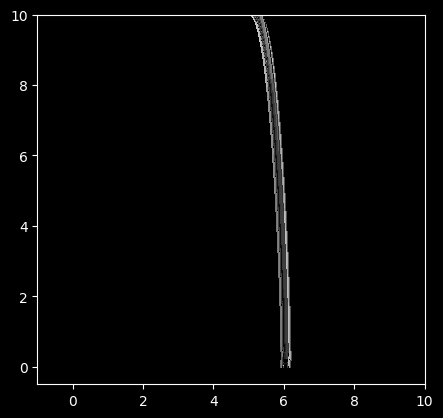

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.cbook as cbook

def get_image():
    # fn = cbook.get_sample_data("necked_tensile_specimen.png")
    # fn = 
    arr = plt.imread('./lander.png')
    # make background transparent
    # you won't have to do this if your car image already has a transparent background
    # mask = (arr == (1,1,1,1)).all(axis=-1)
    # arr[mask] = 0
    return arr

def imshow_affine(ax, z, *args, **kwargs):
    im = ax.imshow(z, *args, **kwargs)
    x1, x2, y1, y2 = im.get_extent()
    im._image_skew_coordinate = (x2, y1)
    return im


pos = (5., 10.)
v = 1.
ts, xs, ys, x_vel, y_vel, ux, uy, tf = lunar_lander(pos, v)

N = 7
# x = np.linspace(0, 1, N)
# y = x**1.1
# heading = np.linspace(10, 90, N)
# trajectory = list(zip(x, y, heading))
degrees = np.arctan(x_vel/y_vel)
# degrees
trajectory = np.array(list(zip(xs, ys, degrees)))
idx = np.round(np.linspace(0, len(trajectory) - 1, N)).astype(int)
np.array(trajectory)[idx]
width = 0.3
lander = get_image()
image_ratio = lander.shape[0]/lander.shape[1]
height = width*image_ratio
# lander.shape[0]/lander.shape[1]
fig, ax = plt.subplots()
for i, t in enumerate(trajectory, start=1):
    xi, yi, deg = t
    im = imshow_affine(ax, lander, interpolation='none',
                       extent=[0, width, 0, height], clip_on=True)
                    #    alpha=0.8*i/len(trajectory))
    center_x, center_y = width//2, height//2
    im_trans = (mtransforms.Affine2D()
                .rotate_deg_around(center_x, center_y, deg)
                .translate(xi, yi)
                + ax.transData)
    im.set_transform(im_trans)

ax.set_xlim(-1, 10)
ax.set_ylim(-0.5, 10)
plt.show()

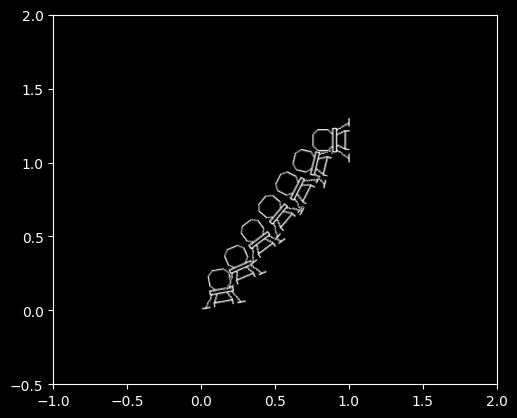

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.cbook as cbook

def get_image():
    # fn = cbook.get_sample_data("necked_tensile_specimen.png")
    # fn = 
    arr = plt.imread('./lander.png')
    # make background transparent
    # you won't have to do this if your car image already has a transparent background
    # mask = (arr == (1,1,1,1)).all(axis=-1)
    # arr[mask] = 0
    return arr

def imshow_affine(ax, z, *args, **kwargs):
    im = ax.imshow(z, *args, **kwargs)
    x1, x2, y1, y2 = im.get_extent()
    im._image_skew_coordinate = (x2, y1)
    return im


pos = (5., 10.)
v = 1.
ts, xs, ys, x_vel, y_vel, ux, uy, tf = lunar_lander(pos, v)

N = 7
x = np.linspace(0, 1, N)
y = x**1.1
heading = np.linspace(10, 90, N)
trajectory = list(zip(x, y, heading))
# degrees = np.arctan(x_vel/y_vel)
# # degrees
# trajectory = np.array(list(zip(xs, ys, degrees)))
# idx = np.round(np.linspace(0, len(trajectory) - 1, N)).astype(int)
# np.array(trajectory)[idx]
width = 0.3
lander = get_image()
image_ratio = lander.shape[0]/lander.shape[1]
height = width*image_ratio
# lander.shape[0]/lander.shape[1]
fig, ax = plt.subplots()
for i, t in enumerate(trajectory, start=1):
    xi, yi, deg = t
    im = imshow_affine(ax, lander, interpolation='none',
                       extent=[0, width, 0, height], clip_on=True)
                    #    alpha=0.8*i/len(trajectory))
    center_x, center_y = width//2, height//2
    im_trans = (mtransforms.Affine2D()
                .rotate_deg_around(center_x, center_y, deg)
                .translate(xi, yi)
                + ax.transData)
    im.set_transform(im_trans)

ax.set_xlim(-1, 2)
ax.set_ylim(-0.5, 2)
plt.show()

In [ ]:
trajectory = list(zip(xs, ys, degrees))
trajectory

16120

In [70]:
pos = (5., 10.)
v = 1.
ts, xs, ys, x_vel, y_vel, ux, uy, tf = lunar_lander(pos, v)

degrees = np.arctan(x_vel/y_vel)
print(np.arctan(x_vel/y_vel))
print(np.arctan(ux/uy))
print(np.min(xs), np.max(xs))
print(np.min(ys), np.max(ys))

[-1.57079633 -1.57064933 -1.57050279 ... -0.37127005 -0.37124018
 -0.37121061]
[ 0.23514968  0.23517239  0.2351951  ... -0.37132073 -0.37126567
 -0.37121061]
5.0 5.908289945616285
-0.037043818729685235 10.0


In [62]:
idx = np.round(np.linspace(0, len(trajectory) - 1, N)).astype(int)
idx

array([    0,   329,   658,   987,  1316,  1645,  1974,  2303,  2632,
        2961,  3290,  3619,  3948,  4276,  4605,  4934,  5263,  5592,
        5921,  6250,  6579,  6908,  7237,  7566,  7895,  8224,  8553,
        8882,  9211,  9540,  9869, 10198, 10527, 10856, 11185, 11514,
       11843, 12171, 12500, 12829, 13158, 13487, 13816, 14145, 14474,
       14803, 15132, 15461, 15790, 16119])

In [64]:
trajectory

[(5.0, 10.0, -1.5707963267948948),
 (5.0001311324029425, 9.999999759997916, -1.5706493317039425),
 (5.000262253115558, 9.999999387445277, -1.5705027901546396),
 (5.000393362137949, 9.999998883074227, -1.5703567022429135),
 (5.000524465785642, 9.999997898717872, -1.5702097062941311),
 (5.000655557742572, 9.999996781952841, -1.5700631640134575),
 (5.0007866380091475, 9.999995533511346, -1.5699170754247513),
 (5.000917712901476, 9.999993805281141, -1.56977007868446),
 (5.001048776103039, 9.999991944784218, -1.5696235356861483),
 (5.001179827614066, 9.999989952752777, -1.5694774465040517),
 (5.00131087375128, 9.99998748105478, -1.569330449050297),
 (5.001441908197359, 9.999984877019322, -1.5691839054172732),
 (5.0015729309530474, 9.999982141378586, -1.569037815672316),
 (5.001703948334512, 9.999978926191833, -1.5688908175372722),
 (5.001834954025377, 9.999975578804914, -1.5687442733078187),
 (5.001965948026519, 9.999972099950034, -1.5685981830681048),
 (5.002096936652905, 9.99996814174248,

In [67]:
np.array(trajectory)[idx].shape

(50, 3)